# To block, or not to block,$\cdots$

## Motivation

### Imagine something is affecting our response variable, $Y_{i=1,2,3,\cdots,n}$, but is unrelated to our treatments, $T_{i=1,2,3,\cdots,p}$. 

### For example, say we are interested in the effect of soybean consumption, $ T_i = \begin{cases} 0 \text{ if the }i^{th }\text{ unit receives the control/no soybeans}\\ 1 \text{ if then}\;i^{th }\text{ unit receives the treatment/soybeans} \end{cases}$, on estrogen levels, $\hat{Y}$, in a population of subjects.

> ### Assume that (i) there is no treament effect and (ii) gender may affect estrogen levels, $\hat{Y}$ but is unrelated to our treatment, $T_i$, such that:

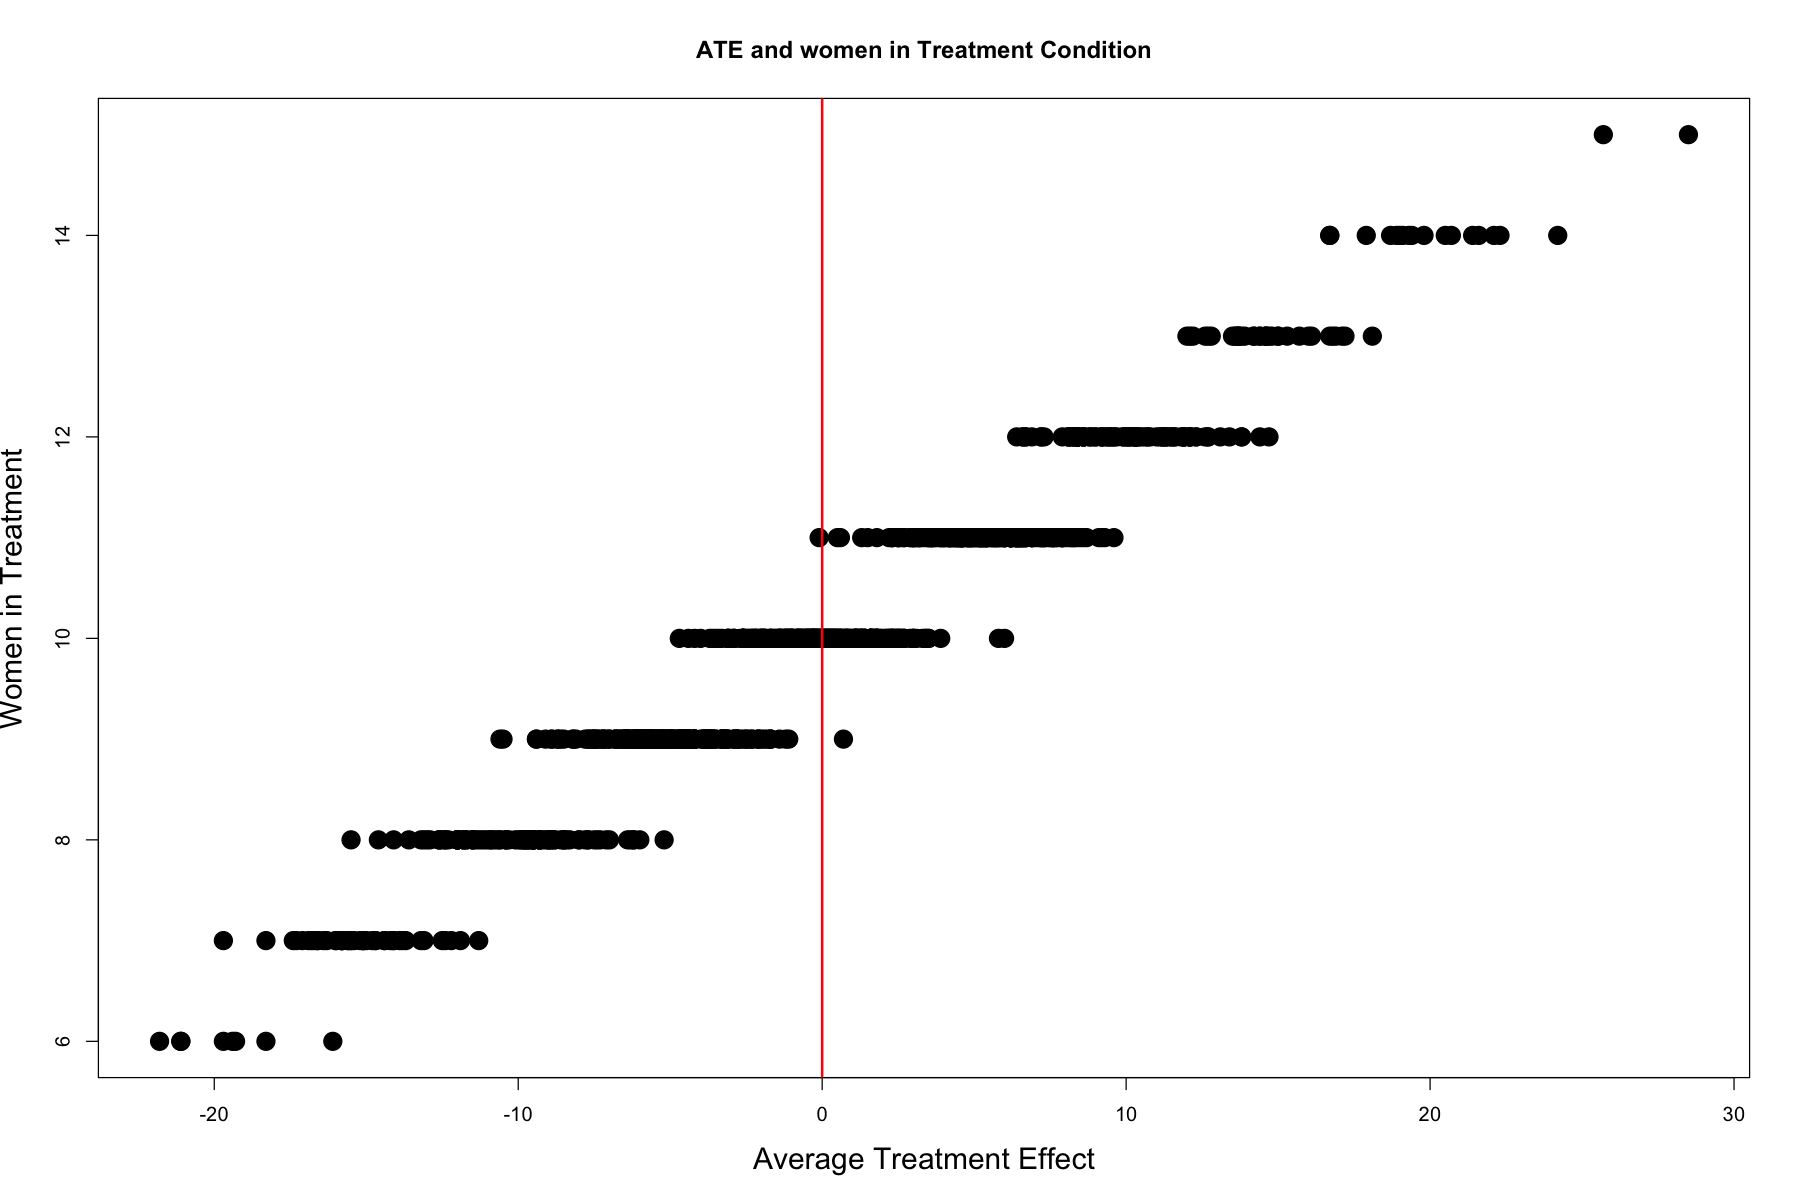

In [1]:
# Change plot size to X x Y
options(repr.plot.width=15, repr.plot.height=10)

# Generate gender group
group <- c(rep("Man",20),
           rep("Woman",20))

# Function to randomly assign people to control=0 and treatment=1
randomize <- function() { 
  sample(c(rep(0, 20), # control
           rep(1, 20))) # treatment
  } 

# Test random assignment
# table(group, randomize())

# Estimate ATE
est_ate <- function(outcome, treatment) { 
  mean(outcome[treatment==1]) - mean(outcome[treatment==0])
  } 

# Set up a series of potential outcomes to treatment and control (which are the same, AKA satisfy the sharp null hypothesis)
sim_normal_study <- function() {
  po_control <- c(seq(from = 1, to = 20), seq(from = 51, to = 70))
  po_treatment <- po_control
  treatment <- randomize()
  outcomes <- po_treatment * treatment + po_control * (1 - treatment)
  ate <- est_ate(outcomes, treatment)
  n_women_treatment <- table(group, treatment)[2, 2]
  return(list(ate = ate, n_women_treatment = n_women_treatment))
}

# Replicate 1000 simulations
results <- t(replicate(1000, sim_normal_study()))
# Plot
plot(results, 
     main = "ATE and women in Treatment Condition", 
     xlab = "Average Treatment Effect", 
     ylab = "Women in Treatment",
     pch=20, cex=3, cex.lab=1.5)
abline(v = 0, col = "red", lwd = 2)

> ###  Imagine we don't know that gender affects $\hat{Y}$ *a-priori*- we could assign all (or even just 12/20) women to treatment, $T_{i=1}$, and all men to control, $T_{i=0}$.
> ###  In this case we might detect a *treatment effect*- but is it meaningful?

### To address this variation in $\hat{Y}$, that is unrelated to the treatment, $T_i$, we can block *on* gender.

> ### Now, imagine that there is a treatment effect, let's look at the precision of our estimates with and without blocking:

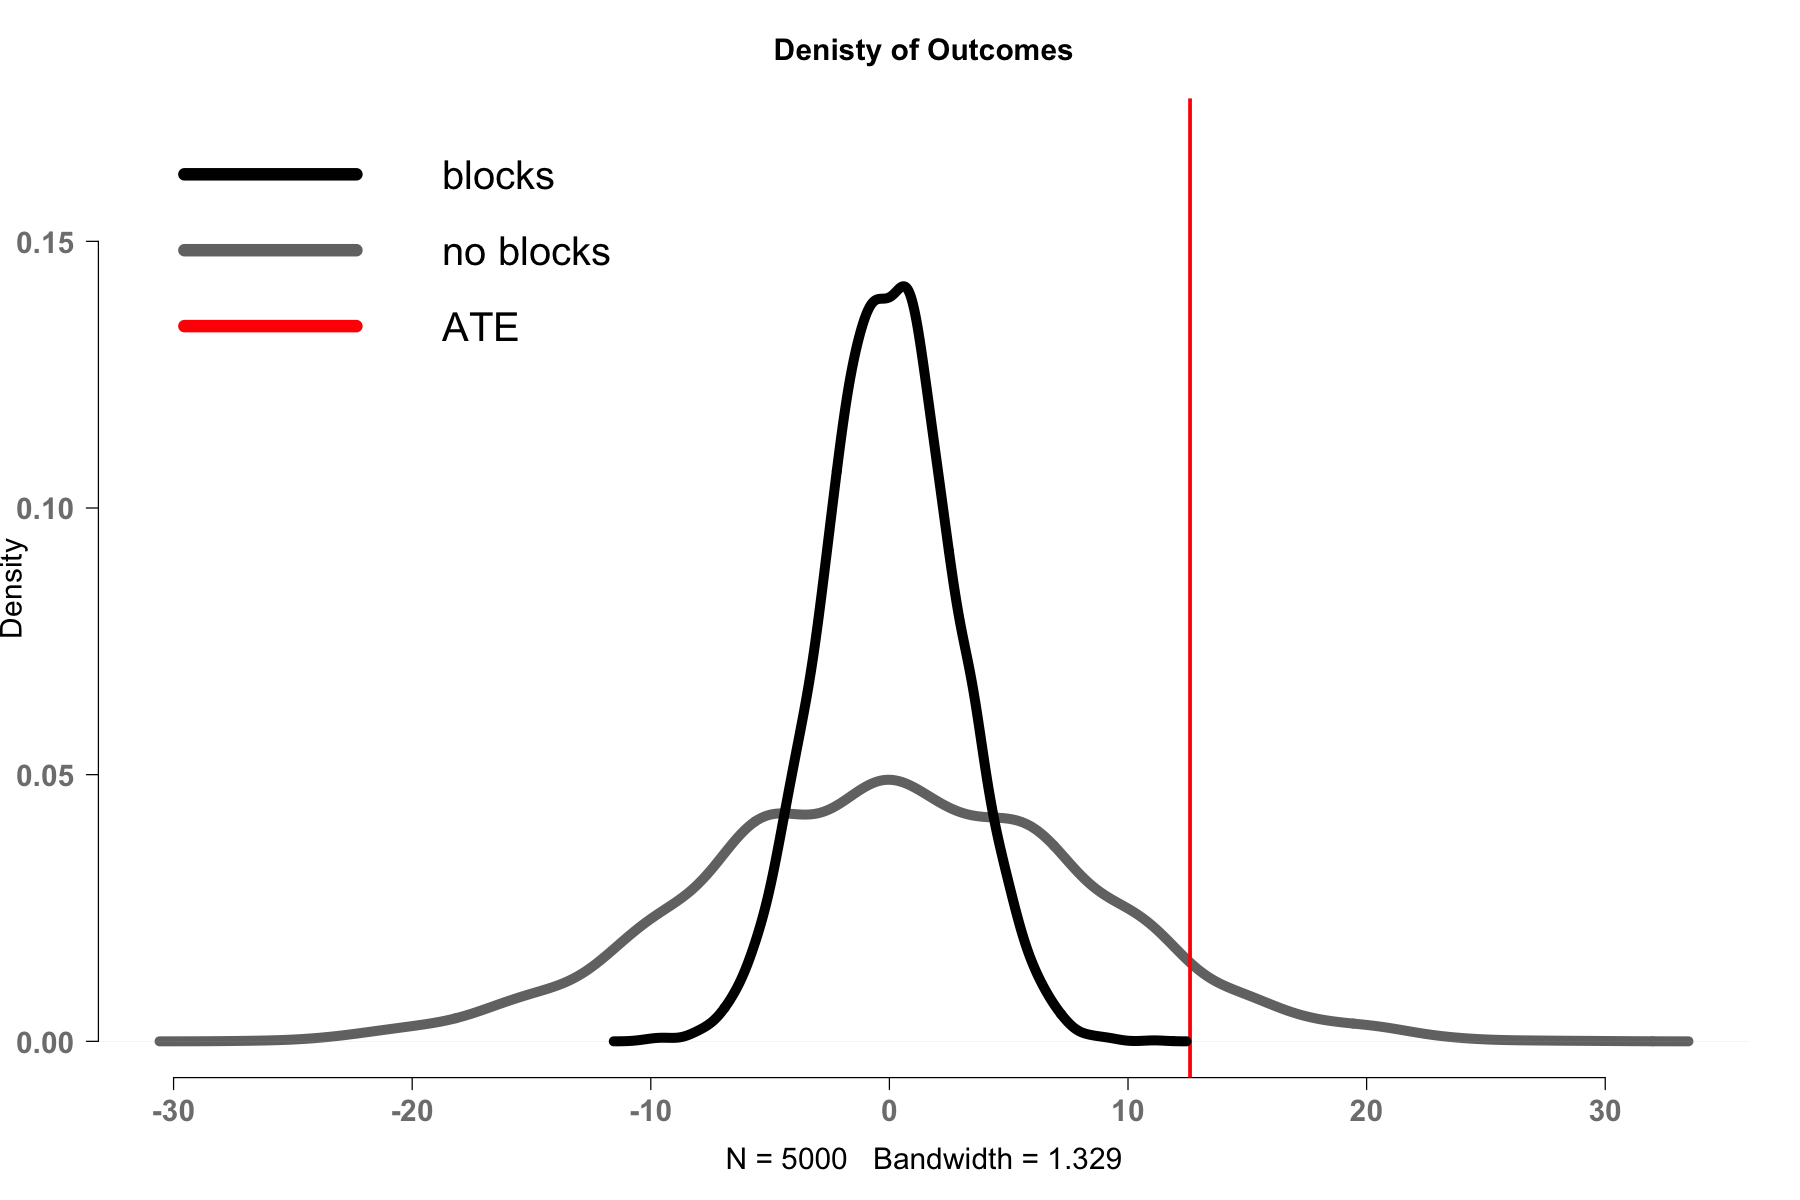

In [2]:
# Change plot size to X x Y
options(repr.plot.width=15, repr.plot.height=10)

# Function to assign treatment and control within blocks
randomize_blocked <- function(){
  c(sample(c(rep(0, 10), rep(1, 10))), #group A
    sample(c(rep(0, 10), rep(1, 10)))) #group B
}

# Control data 
po_control <- c(seq(from = 1, to = 20),
                seq(from = 51, to = 70))
# Treatment data
po_treatment <- po_control + 10 #simulate effect of 10
# Random assignment
treatment_blocked <- randomize_blocked()
# Outcomes
outcomes_blocked <- po_treatment * treatment_blocked + po_control * (1- treatment_blocked)
ate <- est_ate(outcomes_blocked, treatment_blocked)
#ate

# First, under simple random assignment 
sim_normal_study <- function(){
  po_control <- c(seq(from = 1, to = 20), seq(from = 51, to = 70))
  po_treatment <- po_control
  treatment <- randomize()
  outcomes <- po_treatment * treatment + po_control * (1 - treatment)
  ate <- est_ate(outcomes, treatment)
  return(ate)
}

# First, simulate study without blocking
distribution_under_sharp_null <- replicate(5000, sim_normal_study())

# Second, under blocked random assignment 
distribution_under_sharp_null_blocked <- replicate(5000,
est_ate(outcomes_blocked, randomize_blocked()))

# Compare ranges 
# Distribution without blocking
plot(density(distribution_under_sharp_null), 
     main = "Denisty of Outcomes", 
     lwd = 8, col="grey45", 
     ylim=c(0,.17),
    cex.main = 1.5,
    font.lab = 1.5, 
    cex.lab = 1.5,
    font.lab = 1.52,
    cex.axis = 1.5,
    font.axis = 2,
    col.axis = "gray50",
    las = 1,
    mar = c(5.1, 5.1, 4.1, 0.5),
    bty = "n",
    pch = 19)
# Distribution without blocking
abline(v = ate, col = "red", lwd=3)
# mean(ate < distribution_under_sharp_null)
lines(density(distribution_under_sharp_null_blocked), 
      lwd = 8, col= "black")
legend("topleft", legend = c("blocks", "no blocks", "ATE"), 
       lwd = c(10,10,10), lty = c(1,1,1),
       col = c("black", "grey45", "red"),
       cex = 2, bty = "n")

# distribution with blocking
# mean(ate < distribution_under_sharp_null_blocked)

> ### Note that if we assign treatments within each block, gender, the precision of our estimate is less variable than when we randomize across genders.

### Blocking also effects our inferences from linear models. For example:

In [10]:
# Control data- no soybeans
po_control <- c(seq(from = 1, to = 20), seq(from = 51, to = 70))
# Treatment data- soybeans have an effect
po_treatment <- po_control + 10 #simulate effect of 10
# Random assignment
treatment <- randomize()
# Outcomes
outcomes <- po_treatment * treatment + po_control * (1-treatment)


# Linear model without blocking
no_block_lm   <- lm(outcomes ~ treatment)
# Linear model with blocking
with_block_lm <- lm(outcomes ~ treatment + as.factor(group))

# Summaries
# summary(no_block_lm)
# summary(with_block_lm)

# Stargazer
library(stargazer)
stargazer(with_block_lm, no_block_lm,
          title="Results with and without blocks",
          align=TRUE, type="text")


Results with and without blocks
                                   Dependent variable:              
                      ----------------------------------------------
                                         outcomes                   
                                (1)                    (2)          
--------------------------------------------------------------------
treatment                    11.209***              26.100***       
                              (1.978)                (7.904)        
                                                                    
as.factor(group)Woman        49.637***                              
                              (1.978)                               
                                                                    
Constant                     10.077***              27.450***       
                              (1.503)                (5.589)        
                                                                    
-

> ### Note the size of the standard errors, $t$-values, and *p*-values in each model, with and without blocking!

### Finally, blocking influences the efficiency of our designs

> ### Efficiency with blocking

In [11]:
Ewb = 1/(40 - (2-1) - (2-1) - 1) * (mean(summary(no_block_lm)$residuals^2)^2)
Ewb

[1] 9518.377

> ### Efficiency without blocking

In [12]:
Enb = 1/(40-2) * (mean(summary(no_block_lm)$residuals^2)^2 +
                  mean(summary(with_block_lm)$residuals^2)^2)
Enb 

[1] 9296.408

In [13]:
Efficiency = Ewb / Enb 
Efficiency

[1] 1.023877

> ### The design without blocks (CRD) needs $n = n \cdot 1.02 \approx 41$ to achieve the same efficiency as the design with blocks (RCBD).